In [1]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.optimizers import SGD
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
train = pd.read_csv("/home/denis/train.csv")

In [3]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

In [70]:
cnn = Sequential([
    ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.5),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.5),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_uniform'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.25),
    Dense(64, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.125),

    Dense(10, activation='softmax', kernel_initializer='random_uniform')
])

cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [71]:
trainX = train.loc[:, 'pixel0':].as_matrix().astype(int).reshape((-1, 28, 28, 1))
cnn.fit(trainX, keras.utils.to_categorical(train['label']), validation_split=0.2, batch_size=50, epochs=5)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 27s - loss: 0.3450 - acc: 0.8882 - val_loss: 0.1128 - val_acc: 0.9742
Epoch 2/5
33600/33600 [==============================] - 26s - loss: 0.1190 - acc: 0.9665 - val_loss: 0.0958 - val_acc: 0.9824
Epoch 3/5
33600/33600 [==============================] - 26s - loss: 0.1038 - acc: 0.9731 - val_loss: 0.0985 - val_acc: 0.9832
Epoch 4/5
33600/33600 [==============================] - 26s - loss: 0.1026 - acc: 0.9728 - val_loss: 0.0685 - val_acc: 0.9835
Epoch 5/5
33600/33600 [==============================] - 26s - loss: 0.1111 - acc: 0.9729 - val_loss: 0.0972 - val_acc: 0.9763


In [72]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

In [73]:
predictions = cnn.predict(trainX)
decoded = decode_one_hot(predictions)
error_idx = decoded != train['label']
wrong = predictions[error_idx]
true = train['label'][error_idx]

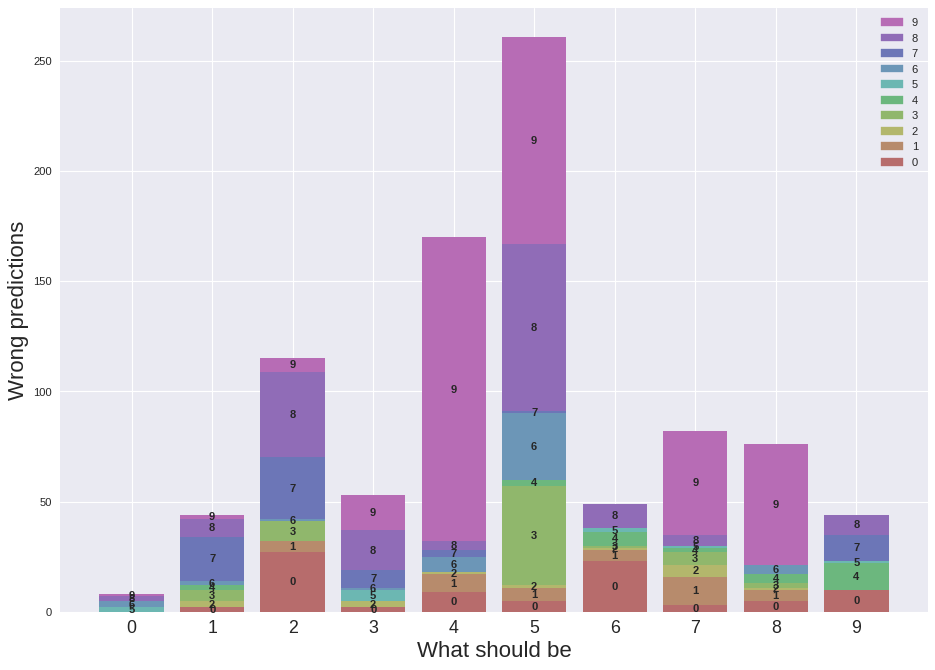

In [74]:
error_plot(decode_one_hot(predictions), train['label'])

In [75]:
def check_certain(certainty):
    return lambda probs: sorted(probs, reverse=True)[0] > certainty
    
uncertain_errors = np.apply_along_axis(lambda x: not check_certain(0.6)(x), 1, wrong).reshape(len(wrong))
certain_errors = np.apply_along_axis(check_certain(0.9), 1, wrong).reshape(len(wrong))

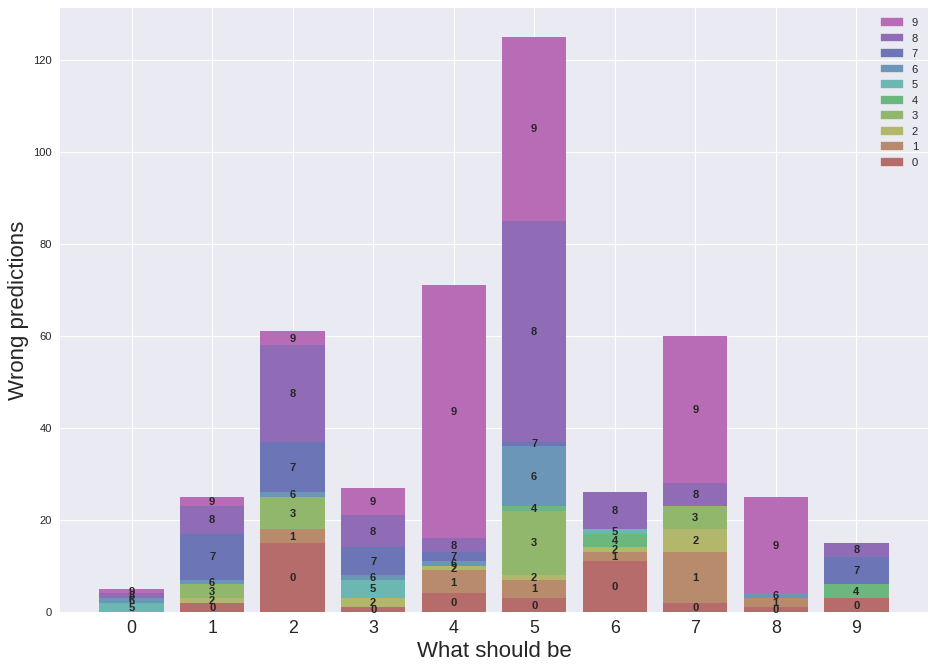

In [76]:
error_plot(decode_one_hot(wrong)[uncertain_errors], true[uncertain_errors])

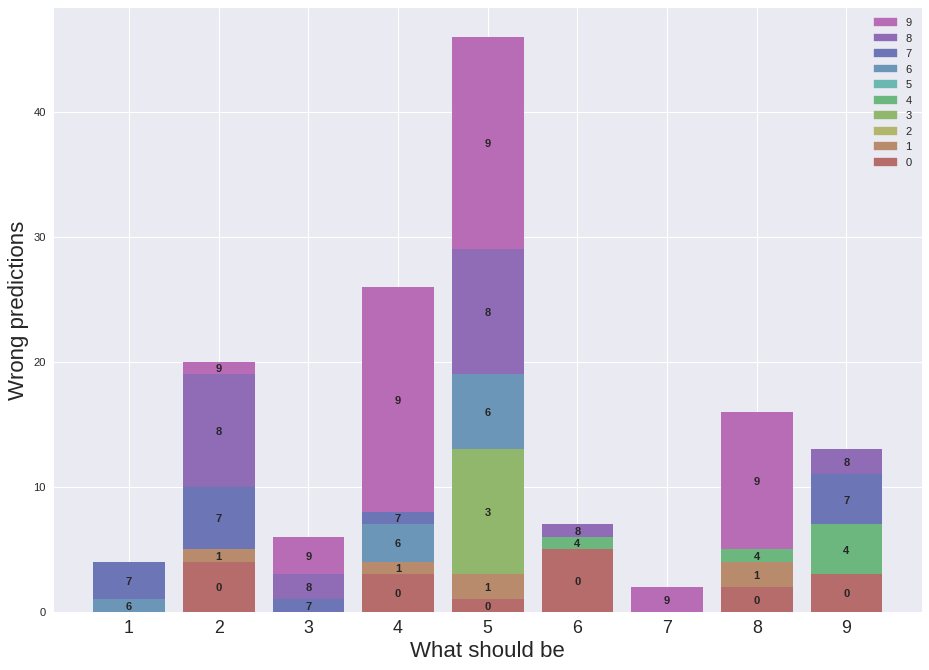

In [77]:
error_plot(decode_one_hot(wrong)[certain_errors], true[certain_errors])

In [78]:
def plot_images_in_grid(images, rows, max_cols):
    images_count = len(images)
    cols = min(max_cols, (images_count / max_cols) + 1)

    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
    for i in range(rows):
        for j in range(cols):
            idx = i*rows + j
            if idx < images_count:
                axes[i, j].imshow(images[idx])
                axes[i, j].axis('off')

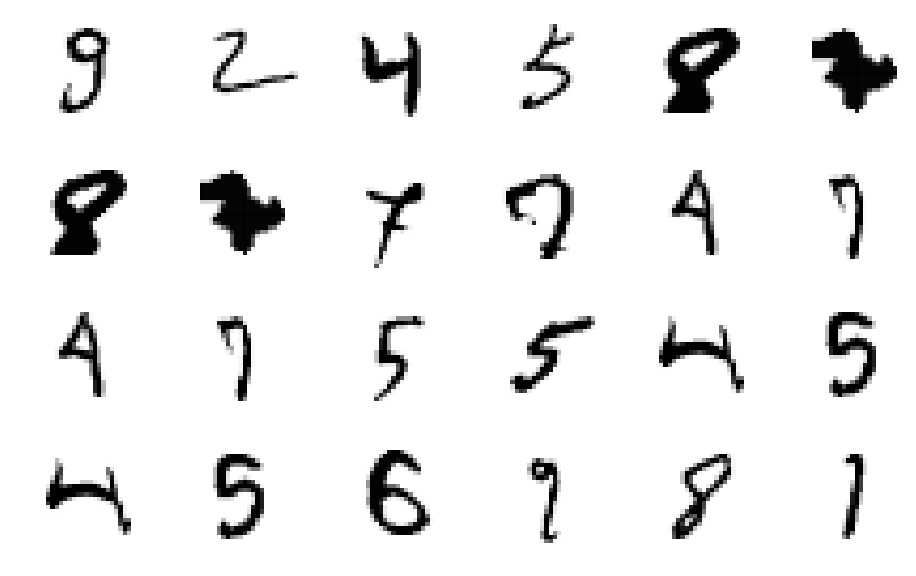

In [79]:
uncertain_images = train[error_idx][uncertain_errors].loc[:, 'pixel0':].as_matrix().reshape((-1, 28, 28))
plot_images_in_grid(uncertain_images, 4, 6)

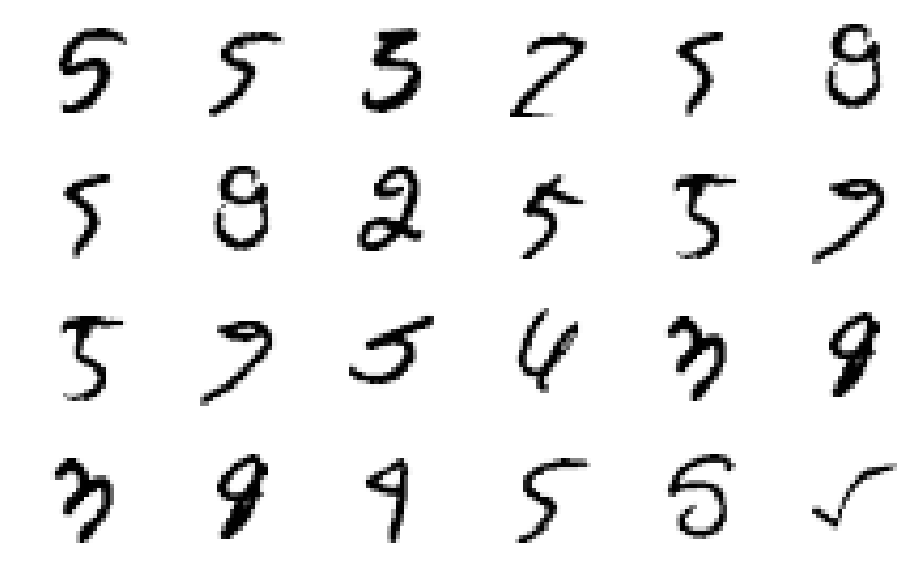

In [80]:
certain_images = train[error_idx][certain_errors].loc[:, 'pixel0':].as_matrix().reshape((-1, 28, 28))
plot_images_in_grid(certain_images, 4, 6)

In [228]:
from sklearn.ensemble import AdaBoostClassifier as ABC

class DigitRecognizer:
    def __init__(self, input_shape=(28, 28, 1), verbose=True, helpers_count=5):
        self.cnn = Sequential([
            ZeroPadding2D(padding=(1, 1), input_shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform'),
            Dropout(0.5),
            ZeroPadding2D(padding=(1, 1)),
            Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            ZeroPadding2D(padding=(1, 1)),
            Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_uniform'),
            Dropout(0.5),
            ZeroPadding2D(padding=(1, 1)),
            Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_uniform'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            Flatten(),
            Dense(512, activation='relu', kernel_initializer='random_uniform'),
            Dropout(0.25),
            Dense(64, activation='relu', kernel_initializer='random_uniform'),
            Dropout(0.125),

            Dense(10, activation='softmax', kernel_initializer='random_uniform')
        ])

        self.cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        self.verbose=verbose
        self.input_shape = input_shape
        self.flat_shape = np.product(input_shape)
        self.helpers_count = helpers_count
        self.helper_classifiers = []
        self.top_errors = []
        
    
    def log(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)
     
    
    def fit(self, X, y, **kwargs):
        self.log("training CNN")
        yy = keras.utils.to_categorical(y)
        self.cnn.fit(X.reshape((-1, *self.input_shape)), yy, **kwargs)
        self.fit_helpers(X, y)
        
        
    def prepare_helpers(self, X, y):
        self.log("training additional predictors")
        predictions = self.cnn.predict(X)
        decoded = self.decode_one_hot(predictions)
        
        error_idx = decoded != y
        true = y[error_idx]
        wrong = predictions[error_idx]
        uncertain_errors = np.apply_along_axis(lambda x: not check_certain(0.5)(x),
                                               1,
                                               wrong).reshape(len(wrong))
        
        self.top_errors = self.get_top_errors(keras.utils.to_categorical(wrong), true)
        
        self.helper_classifiers = [ABC() for i in range(self.helpers_count)]
        
        datasets = [] # list of datasets for each helper predictor
        for err in self.top_errors:
            idx = ((y == err[0]) | (y == err[1]))
            datasets.append((X[idx].reshape((-1, self.flat_shape)), y[idx]))
        
        return datasets
    
    
    def fit_helpers(self, X, y):
        datasets = self.prepare_helpers(X, y)
        for i, (dataset, helper) in enumerate(zip(datasets, self.helper_classifiers)):
            self.log("training helper #%d" % i)
            helper.fit(dataset[0], dataset[1])
        
    
    def get_top_errors(self, wrong, true):    
        xs, ys = np.fromfunction(lambda x, y, z: (x, y), shape=(10, 10, 1), dtype=int)
        zeros = np.zeros((10, 10, 1), dtype=int)
        errors_map = np.concatenate((xs, ys, zeros), axis=2)
            
        for w, t in zip(wrong, true):
            if w > t:
                w, t = t, w
            errors_map[int(w), int(t), 2] += 1
        
        return np.array(sorted(errors_map.reshape((100, 3)),
                               key=lambda x: x[2], reverse=True)[:self.helpers_count])
    
    
    def decode_one_hot(self, encoded):
        return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

    
    def check_certain(certainty):
        return lambda probs: sorted(probs, reverse=True)[0] > certainty

    
    def predict(self, X):
        predictions = self.cnn.predict(X)
        #decoded = self.decode_one_hot(predictions)
        #uncertain_predictions = np.apply_along_axis(lambda x: not check_certain(0.25)(x),
        #                               1,
        #                               predictions).reshape(len(predictions))
        #XX = X.reshape((-1, self.flat_shape))
        #additional_predictions = []
        return predictions
    
model = DigitRecognizer()

In [225]:
model = DigitRecognizer()
model.fit(trainX[:1000], train['label'][:1000], epochs=1)

training CNN
Epoch 1/1
1000/1000 [==============================] - 2s - loss: 2.3527 - acc: 0.1960     
training additional predictors
training helper #0
training helper #1
training helper #2
training helper #3
training helper #4
